# e-Commerce Sales Analysis
This notebook performs exploratory data analysis and RFM/customer segmentation on the provided realistic e-commerce sales dataset.
Dataset: `realistic_e_commerce_sales_data.csv`
Goals: Inspect & clean data, visualize key metrics, compute customer RFM and clusters, and export summarized dataframes for downstream use.

In [ ]:
# Install required packages (uncomment and run if needed)
# Note: In most environments these packages are already available.
!pip install pandas matplotlib seaborn numpy scikit-learn openpyxl

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Plot styling
sns.set(style="whitegrid")

In [6]:
# Load dataset and inspect
df = pd.read_csv('realistic_e_commerce_sales_data.csv')
print('Shape:', df.shape)
display(df.head(10))

print('Missing values by column:\n', df.isnull().sum())

Shape: (1000, 12)


,Customer ID,Gender,Region,Age,Product Name,Category,Unit Price,Quantity,Total Price,Shipping Fee,Shipping Status,Order Date
0,CUST0268,Male,North,NaN,Monitor,Electronics,300.0,5,1500,13.31,Returned,2023-12-08
1,CUST0046,Male,West,22.0,Headphones,Accessories,100.0,2,200,6.93,In Transit,2023-04-09
2,CUST0169,Female,South,54.0,Monitor,Electronics,300.0,1,300,11.31,Returned,2023-08-28
3,CUST0002,Male,North,23.0,Headphones,Accessories,100.0,5,500,12.22,Delivered,2023-01-18
4,CUST0173,Female,South,NaN,Laptop,Electronics,1500.0,3,4500,5.40,Delivered,2023-01-19
5,CUST0147,Male,North,64.0,Smartwatch,Wearables,200.0,2,400,11.26,In Transit,2023-01-11
6,CUST0262,Male,East,27.0,Smartwatch,Wearables,200.0,1,200,18.38,In Transit,2023-10-23
7,CUST0159,Female,South,18.0,Keyboard,Accessories,50.0,2,100,15.08,Returned,2023-06-15
8,CUST0046,Female,East,22.0,Mouse,Accessories,30.0,1,30,8.22,Returned,2023-02-25
9,CUST0023,Male,West,29.0,Headphones,Accessories,100.0,3,300,10.70,Delivered,2023-04-23


Missing values by column:
 Customer ID          0
Gender               0
Region              50
Age                100
Product Name         0
Category             0
Unit Price           0
Quantity             0
Total Price          0
Shipping Fee         0
Shipping Status     50
Order Date           0
dtype: int64


## Data Cleaning
Perform conservative cleaning: drop irrelevant columns, fix shipping status, remove duplicates and parse dates.
We keep important transactional columns for analysis (Order Date, Customer ID, Product Name, Quantity, Total Price, Shipping Fee, Shipping Status, Category).

In [7]:
# Keep only relevant columns if additional demographic columns exist
cols_keep = ['Order Date','Customer ID','Product Name','Quantity','Total Price','Shipping Fee','Shipping Status','Category']
df = df[[c for c in cols_keep if c in df.columns]].copy()

# Fix Shipping Status forward-fill small gaps and normalize values
if 'Shipping Status' in df.columns:
    df['Shipping Status'] = df['Shipping Status'].ffill()
    df['Shipping Status'] = df['Shipping Status'].map({'Delivered':'Delivered','In Transit':'Delivered','Returned':'Returned'}).fillna(df['Shipping Status'])

# Drop exact duplicates and reset index
df = df.drop_duplicates().reset_index(drop=True)

# Parse dates and create helpful date parts
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day
df['Order Year'] = df['Order Date'].dt.year
df['Is Weekend'] = df['Order Date'].dt.dayofweek.isin([5,6])

# Keep only 2023 data for consistency with the original analysis (if present)
if 'Order Year' in df.columns and 2023 in df['Order Year'].unique():
    df = df[df['Order Year'] == 2023].copy()

print('Cleaned shape:', df.shape)
display(df.head())

Cleaned shape: (980, 12)


,Order Date,Customer ID,Product Name,Quantity,Total Price,Shipping Fee,Shipping Status,Category,Order Month,Order Day,Order Year,Is Weekend
0,2023-12-08,CUST0268,Monitor,5,1500,13.31,Returned,Electronics,12,8,2023,False
1,2023-04-09,CUST0046,Headphones,2,200,6.93,Delivered,Accessories,4,9,2023,True
2,2023-08-28,CUST0169,Monitor,1,300,11.31,Returned,Electronics,8,28,2023,False
3,2023-01-18,CUST0002,Headphones,5,500,12.22,Delivered,Accessories,1,18,2023,False
4,2023-01-19,CUST0173,Laptop,3,4500,5.40,Delivered,Electronics,1,19,2023,False


## Exploratory Visualizations
Quick visual checks: revenue over time and top products. Adjust figures in your environment as needed.

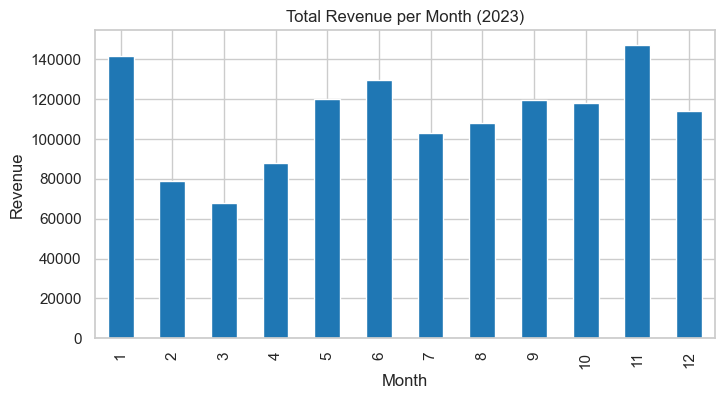

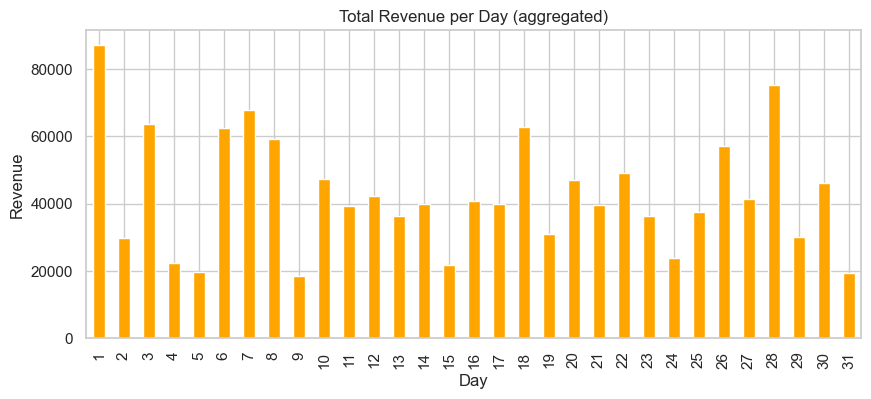

In [8]:
# Revenue by month (bar)
if 'Order Month' in df.columns and 'Total Price' in df.columns:
    revenue_per_month = df.groupby('Order Month')['Total Price'].sum().sort_index()
    plt.figure(figsize=(8,4))
    revenue_per_month.plot(kind='bar', color='tab:blue')
    plt.title('Total Revenue per Month (2023)')
    plt.xlabel('Month')
    plt.ylabel('Revenue')
    plt.show()

# Revenue by day of month (bar)
if 'Order Day' in df.columns and 'Total Price' in df.columns:
    revenue_per_day = df.groupby('Order Day')['Total Price'].sum()
    plt.figure(figsize=(10,4))
    revenue_per_day.plot(kind='bar', color='orange')
    plt.title('Total Revenue per Day (aggregated)')
    plt.xlabel('Day')
    plt.ylabel('Revenue')
    plt.show()

C:\Users\asemh\AppData\Local\Temp\ipykernel_17004\1260596988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='Blues_r')


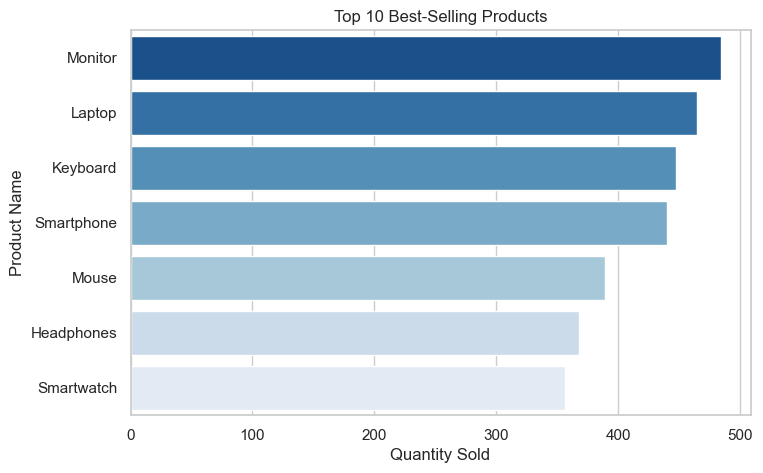

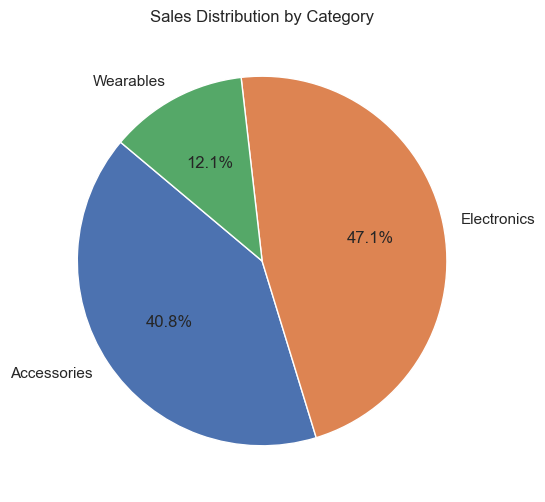

In [9]:
# Top products and category distribution
if 'Product Name' in df.columns and 'Quantity' in df.columns:
    top_products = df.groupby('Product Name')['Quantity'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_products.values, y=top_products.index, palette='Blues_r')
    plt.title('Top 10 Best-Selling Products')
    plt.xlabel('Quantity Sold')
    plt.ylabel('Product Name')
    plt.show()

if 'Category' in df.columns and 'Quantity' in df.columns:
    sales_per_category = df.groupby('Category')['Quantity'].sum()
    plt.figure(figsize=(6,6))
    sales_per_category.plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title('Sales Distribution by Category')
    plt.ylabel('')
    plt.show()

## Customer RFM and Segmentation
Compute Recency, Frequency, Monetary (RFM) features per customer, then run k-means clustering and create simple RFM scores.

In [10]:
# Group by customer to compute R, F, M
grouped_by_customer = df.groupby('Customer ID')[['Total Price','Quantity']].sum().rename(columns={'Total Price':'TotalPrice','Quantity':'TotalQuantity'})
aov_per_customer = (grouped_by_customer['TotalPrice'] / grouped_by_customer['TotalQuantity']).rename('AOV').fillna(0)

# Use a fixed current date for Recency calculation (adjust if needed)
import datetime
current_time = datetime.datetime(2024,1,1)
last_customer_order_date = df.groupby('Customer ID')['Order Date'].max()
recency = (current_time - pd.to_datetime(last_customer_order_date)).dt.days.rename('Recency')
frequency = df['Customer ID'].value_counts().rename('Frequency')
monetary = df.groupby('Customer ID')['Total Price'].sum().rename('Monetary')

# Shipping status and average shipping percentage per customer
customer_shipping_status = df.groupby(['Customer ID','Shipping Status']).size().unstack(fill_value=0) if 'Shipping Status' in df.columns else pd.DataFrame()
df['Shipping Percentage'] = (df['Shipping Fee'] / df['Total Price'] * 100).replace([np.inf, -np.inf], np.nan) if 'Shipping Fee' in df.columns and 'Total Price' in df.columns else np.nan
percentage_shipFee_by_customer = df.groupby('Customer ID')['Shipping Percentage'].mean().rename('Avg Shipping %') if 'Shipping Percentage' in df.columns else pd.Series(dtype=float)

# Build customers_summary DataFrame and reset index
customers_summary = pd.concat([recency, frequency, monetary, percentage_shipFee_by_customer, aov_per_customer], axis=1)
customers_summary = customers_summary.rename(columns={'Total Price':'Monetary'})
customers_summary = customers_summary.reset_index().rename(columns={'index':'Customer ID'})
display(customers_summary.head())

,Customer ID,Recency,Frequency,Monetary,Avg Shipping %,AOV
0,CUST0001,250,2,6150,2.140667,878.571429
1,CUST0002,113,3,1550,3.736000,140.909091
2,CUST0003,56,3,4890,3.866898,407.500000
3,CUST0004,3,4,5300,4.219361,331.250000
4,CUST0005,320,1,60,12.633333,30.000000


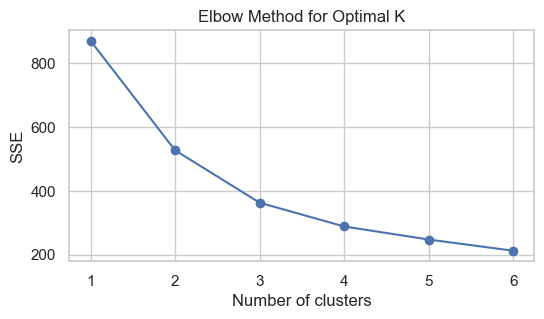

,Cluster,Recency,Frequency,Monetary,AOV,Count
0,0,75.623077,2.484615,2800.153846,410.826899,130
1,1,49.187500,4.906250,6490.520833,467.029198,96
2,2,46.562500,6.375000,16492.500000,820.457242,16
3,3,246.895833,1.750000,1754.791667,342.508012,48


In [11]:
# Clustering (k-means) on scaled RFM features and simple RFM scoring
rfm_df = customers_summary[['Recency','Frequency','Monetary']].fillna(0).copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

# Elbow (quick check)
sse = []
K_range = range(1,7)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(6,3))
plt.plot(K_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.show()

# Choose k (4 is a reasonable default used previously)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
customers_summary['Cluster'] = kmeans.fit_predict(rfm_scaled)

# RFM scoring via quantiles
customers_summary['R_Score'] = pd.qcut(customers_summary['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1]).astype(int)
customers_summary['F_Score'] = pd.qcut(customers_summary['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
customers_summary['M_Score'] = pd.qcut(customers_summary['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
customers_summary['RFM_Score'] = customers_summary['R_Score'].astype(str) + customers_summary['F_Score'].astype(str) + customers_summary['M_Score'].astype(str)

cluster_summary = customers_summary.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'AOV':'mean' if 'AOV' in customers_summary.columns else 'first',
    'Customer ID':'count'
}).rename(columns={'Customer ID':'Count'}).reset_index()

display(cluster_summary)

In [12]:
# RFM summary by RFM_Score (optional)
rfm_summary = customers_summary.groupby('RFM_Score').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'Customer ID':'count'
}).rename(columns={'Customer ID':'Count'}).reset_index()
display(rfm_summary.head())

,RFM_Score,Recency,Frequency,Monetary,Count
0,111,283.263158,1.000000,399.473684,19
1,112,269.000000,1.333333,1530.000000,3
2,113,201.500000,1.500000,3675.000000,4
3,114,226.000000,1.500000,6075.000000,2
4,115,164.000000,2.000000,7800.000000,1


In [13]:
# Export important DataFrames to CSV and Excel for downstream use
outputs = {}
try:
    df.to_csv('cleaned_transactions.csv', index=False)
    outputs['cleaned_transactions.csv'] = True
except Exception as e:
    outputs['cleaned_transactions.csv'] = str(e)

try:
    customers_summary.to_csv('customers_summary.csv', index=False)
    outputs['customers_summary.csv'] = True
except Exception as e:
    outputs['customers_summary.csv'] = str(e)

try:
    rfm_summary.to_csv('rfm_summary.csv', index=False)
    outputs['rfm_summary.csv'] = True
except Exception as e:
    outputs['rfm_summary.csv'] = str(e)

# Save Excel workbook with key sheets if openpyxl is available
try:
    with pd.ExcelWriter('customers_and_transactions.xlsx', engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name='transactions', index=False)
        customers_summary.to_excel(writer, sheet_name='customers_summary', index=False)
        rfm_summary.to_excel(writer, sheet_name='rfm_summary', index=False)
    outputs['customers_and_transactions.xlsx'] = True
except Exception as e:
    outputs['customers_and_transactions.xlsx'] = str(e)

print('Export results:')
print(outputs)

Export results:
{'cleaned_transactions.csv': True, 'customers_summary.csv': True, 'rfm_summary.csv': True, 'customers_and_transactions.xlsx': True}
